# Conditional GAN

This notebook demonstrates the use of a GAN trained on the MNIST dataset and conditioned on class labels.

## Install and Import packages

In [ ]:
# %pip install numpy torch torchvision torch-summary Pillow ipython seaborn imageio

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from IPython.display import Video, display
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms
from typing import Any, List, Optional, Union

Set fixed seed for reproducibility

In [2]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

## Helper functions

In [3]:
def pt_to_numpy(images: torch.FloatTensor) -> np.ndarray:
    return images.detach().cpu().permute(0, 2, 3, 1).float().numpy()


def numpy_to_pt(images: np.ndarray) -> torch.FloatTensor:
    if images.ndim == 3:
        images = images[..., None]
    return torch.from_numpy(images.transpose(0, 3, 1, 2))


def numpy_to_pil(images: np.ndarray) -> Image.Image:
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def pil_to_numpy(images: Union[List[Image.Image], Image.Image]) -> np.ndarray:
    if not isinstance(images, Image.Image) and not isinstance(images, list):
        raise ValueError(
            f"Expected PIL image or list of PIL images, got {type(images)}."
        )
    if not isinstance(images, list):
        images = [images]
    images = [np.array(image).astype(np.float32) / 255.0 for image in images]
    images = np.stack(images, axis=0)
    return images


def normalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return 2.0 * images - 1.0


def denormalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return (0.5 + images / 2).clamp(0, 1)


def pil_to_video(images: List[Image.Image], filename: str, fps: int = 60) -> None:
    frames = [np.array(image) for image in images]
    with imageio.get_writer(filename, fps=fps) as video_writer:
        for frame in frames:
            video_writer.append_data(frame)


def image_grid(images: List[Image.Image], rows: int, cols: int) -> Image.Image:
    if len(images) > rows * cols:
        raise ValueError(
            f"Number of images ({len(images)}) exceeds grid size ({rows}x{cols})."
        )
    w, h = images[0].size
    grid = Image.new("L", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

### Load Dataset

Here, we load the MNIST dataset. We use a fixed subset of the dataset to speed up the training process since this is a simple demo. We convert the images to tensors and normalize values to the range [-1, 1].

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
subset_size = 20000

In [5]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
    ),
    download=True,
)
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

#### Visualize training dataset

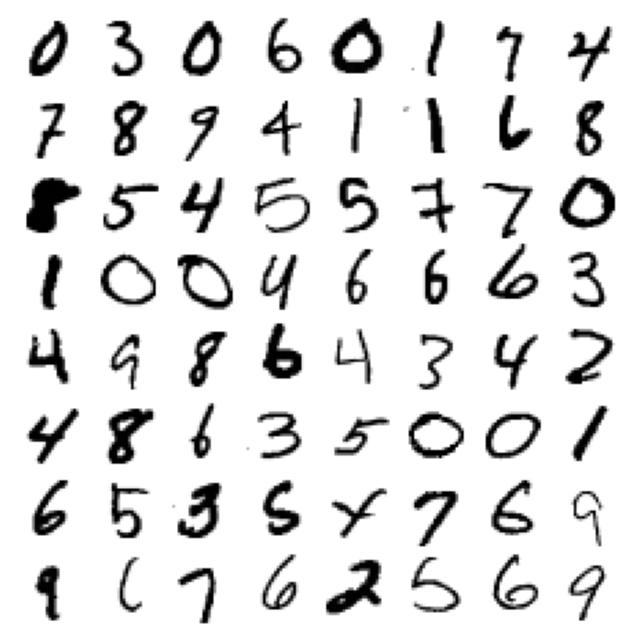

In [6]:
for batch_images, batch_labels in dataloader:
    rows = int(batch_size**0.5)
    if rows * rows < batch_size:
        rows += 1
    cols = rows
    batch_images = numpy_to_pil(pt_to_numpy(denormalize(batch_images)))
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image_grid(batch_images, rows=rows, cols=cols), cmap="binary")
    plt.axis("off")
    plt.show()
    break

## Creating Models

We define the Generator and Discriminator - components of a GAN.

In [7]:
class Generator(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        latent_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        dropout: float = 0.4,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.device = device

        if len(hidden_dims) < 1:
            raise ValueError(
                f"hidden_dims should have length of atleast 1, but got {len(hidden_dims)}"
            )

        def block(in_dim: int, out_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(0.25, inplace=True),
                nn.Dropout(dropout),
            )

        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, embedding_dim=embedding_dim
        )
        self.model = nn.Sequential()

        self.model.append(block(latent_dim + embedding_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.model.append(block(hidden_dims[i - 1], hidden_dims[i]))
        self.model.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model.append(nn.Tanh())

        self.to(device)

    def forward(
        self, latent: torch.FloatTensor, labels: torch.LongTensor
    ) -> torch.FloatTensor:
        latent = latent.to(self.device)
        labels = labels.to(self.device)

        latent = latent.view(-1, self.latent_dim)
        embedding = self.embedding(labels).view(-1, self.embedding_dim)
        x = torch.cat([latent, embedding], dim=1)
        x = self.model(x)

        return x.view(-1, 28, 28)

In [8]:
class Discriminator(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        dropout: float = 0.4,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.device = device

        if len(hidden_dims) < 1:
            raise ValueError(
                f"hidden_dims should have length of atleast 1, but got {len(hidden_dims)}"
            )

        def block(in_dim: int, out_dim: int) -> nn.Sequential:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(0.25, inplace=True),
                nn.Dropout(dropout),
            )

        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, embedding_dim=embedding_dim
        )
        self.model = nn.Sequential()

        self.model.append(block(input_dim + embedding_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.model.append(block(hidden_dims[i - 1], hidden_dims[i]))
        self.model.append(nn.Linear(hidden_dims[-1], output_dim))
        self.model.append(nn.Sigmoid())

        self.to(device)

    def forward(
        self, images: torch.FloatTensor, labels: torch.LongTensor
    ) -> torch.FloatTensor:
        images = images.to(self.device)
        labels = labels.to(self.device)

        images = images.view(-1, 28 * 28)
        embedding = self.embedding(labels).view(-1, self.embedding_dim)
        x = torch.cat([images, embedding], dim=1)
        x = self.model(x)

        return x.squeeze()

#### Configure Hyperparameters for Training

In [9]:
epochs = 40
learning_rate_g = 1e-4
learning_rate_d = 3e-4
steps_g = 2
steps_d = 3
latent_dim = 128
num_embeddings = 10  # 10 classes in MNIST
embedding_dim = 10
dropout = 0.4
log_steps = 100

generator_hidden_dims = [256, 512, 1024]
discriminator_hidden_dims = [1024, 512, 256]

In [10]:
generator = Generator(
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    output_dim=28 * 28,
    hidden_dims=generator_hidden_dims,
    dropout=dropout,
    device=device,
)
discriminator = Discriminator(
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    input_dim=28 * 28,
    output_dim=1,
    hidden_dims=discriminator_hidden_dims,
    dropout=dropout,
    device=device,
)

In [11]:
_ = summary(
    generator,
    [(1, latent_dim), (1,)],
    dtypes=[torch.FloatTensor, torch.LongTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 1, 10]               100
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Sequential: 2-1                   [-1, 256]                 --
|    |    └─Linear: 3-1                  [-1, 256]                 35,584
|    |    └─LeakyReLU: 3-2               [-1, 256]                 --
|    |    └─Dropout: 3-3                 [-1, 256]                 --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-4                  [-1, 512]                 131,584
|    |    └─LeakyReLU: 3-5               [-1, 512]                 --
|    |    └─Dropout: 3-6                 [-1, 512]                 --
|    └─Sequential: 2-3                   [-1, 1024]                --
|    |    └─Linear: 3-7                  [-1, 1024]                525,312
|    |    └─LeakyReLU: 3-8               [-1, 1024]                --


In [12]:
_ = summary(
    discriminator,
    [(1, 28, 28), (1,)],
    dtypes=[torch.FloatTensor, torch.LongTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 1, 10]               100
├─Sequential: 1-2                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 1024]                --
|    |    └─Linear: 3-1                  [-1, 1024]                814,080
|    |    └─LeakyReLU: 3-2               [-1, 1024]                --
|    |    └─Dropout: 3-3                 [-1, 1024]                --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-4                  [-1, 512]                 524,800
|    |    └─LeakyReLU: 3-5               [-1, 512]                 --
|    |    └─Dropout: 3-6                 [-1, 512]                 --
|    └─Sequential: 2-3                   [-1, 256]                 --
|    |    └─Linear: 3-7                  [-1, 256]                 131,328
|    |    └─LeakyReLU: 3-8               [-1, 256]                 --

## Training

In [13]:
loss = nn.BCELoss()
optim_g = torch.optim.AdamW(generator.parameters(), lr=learning_rate_g)
optim_d = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate_d)

In [14]:
def trainstep_g():
    optim_g.zero_grad()

    latent = torch.randn((batch_size, latent_dim))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = generator(latent, fake_labels)

    validity = discriminator(fake_images, fake_labels)
    fake_loss = loss(validity, torch.ones(batch_size, device=device))

    fake_loss.backward()
    optim_g.step()

    return fake_loss

In [15]:
def trainstep_d(images, labels):
    optim_d.zero_grad()

    # We can't use the global batch_size because dataloader may have truncation
    # for last uncomplete batch
    batch_size = images.shape[0]

    real_validity = discriminator(images, labels)
    real_loss = loss(real_validity, torch.ones(batch_size, device=device))

    latent = torch.randn((batch_size, latent_dim))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = generator(latent, fake_labels)

    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = loss(fake_validity, torch.zeros(batch_size, device=device))

    discriminator_loss = (real_loss + fake_loss) / 2

    discriminator_loss.backward()
    optim_d.step()

    return discriminator_loss

In [16]:
grid_images = []
generator_losses = []
discriminator_losses = []

In [17]:
def train(epochs: int):
    steps = 0
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        generator.train()

        for index, (images, labels) in enumerate(dataloader):
            generator_loss = 0
            discriminator_loss = 0

            for _ in range(steps_g):
                generator_loss += trainstep_g().mean().item()
            for _ in range(steps_d):
                discriminator_loss += trainstep_d(images, labels).mean().item()

            generator_losses.append(generator_loss / steps_g)
            discriminator_losses.append(discriminator_loss / steps_d)

            if steps % log_steps == 0:
                print(
                    f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
                )
            steps += 1

        print(
            f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
        )
        print("-" * 64)

        grid_image = visualize()
        grid_images.append(grid_image)

        if epoch % 4 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(grid_image, cmap="binary")
            plt.axis("off")
            plt.show()


def visualize():
    labels = torch.arange(0, 10).unsqueeze(dim=-1).repeat(1, 10)

    with torch.no_grad():
        generator.eval()

        latents = torch.randn((100, latent_dim))
        sampled_images = generator(latents, labels).unsqueeze(dim=1)
        sampled_images = numpy_to_pil(pt_to_numpy(denormalize(sampled_images)))
        grid_image = image_grid(sampled_images, rows=10, cols=10)

    return grid_image

Epoch: 0, Generator loss: 1.3706, Discriminator loss: 1.8123
Epoch: 0, Generator loss: 28.4788, Discriminator loss: 0.0550
Epoch: 0, Generator loss: 20.0829, Discriminator loss: 0.2769
Epoch: 0, Generator loss: 12.8826, Discriminator loss: 0.2952
Epoch: 0, Generator loss: 10.4026, Discriminator loss: 0.1695
----------------------------------------------------------------


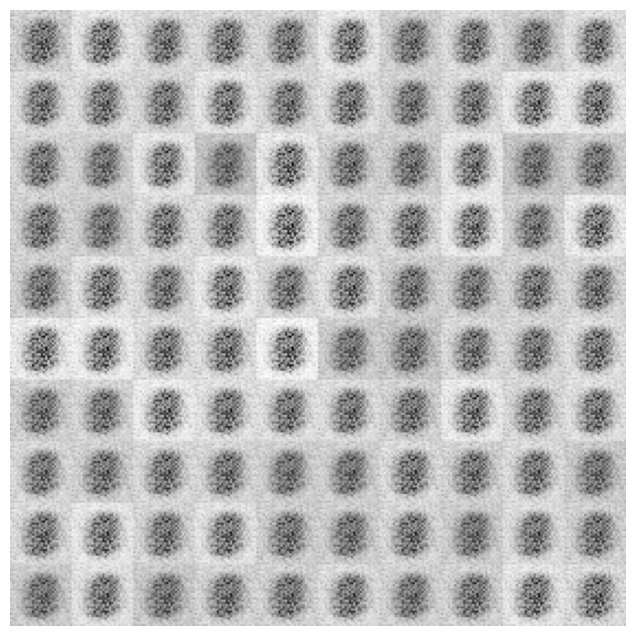

Epoch: 1, Generator loss: 18.2226, Discriminator loss: 0.1302
Epoch: 1, Generator loss: 13.8208, Discriminator loss: 0.1252
Epoch: 1, Generator loss: 12.5849, Discriminator loss: 0.1306
Epoch: 1, Generator loss: 15.8439, Discriminator loss: 0.1946
----------------------------------------------------------------
Epoch: 2, Generator loss: 13.1313, Discriminator loss: 0.0726
Epoch: 2, Generator loss: 18.7799, Discriminator loss: 0.0856
Epoch: 2, Generator loss: 10.3745, Discriminator loss: 0.3227
Epoch: 2, Generator loss: 7.5461, Discriminator loss: 0.3282
----------------------------------------------------------------
Epoch: 3, Generator loss: 10.9095, Discriminator loss: 0.1905
Epoch: 3, Generator loss: 10.1184, Discriminator loss: 0.2821
Epoch: 3, Generator loss: 12.2235, Discriminator loss: 0.2334
Epoch: 3, Generator loss: 15.0539, Discriminator loss: 0.0434
----------------------------------------------------------------
Epoch: 4, Generator loss: 13.2869, Discriminator loss: 0.3020


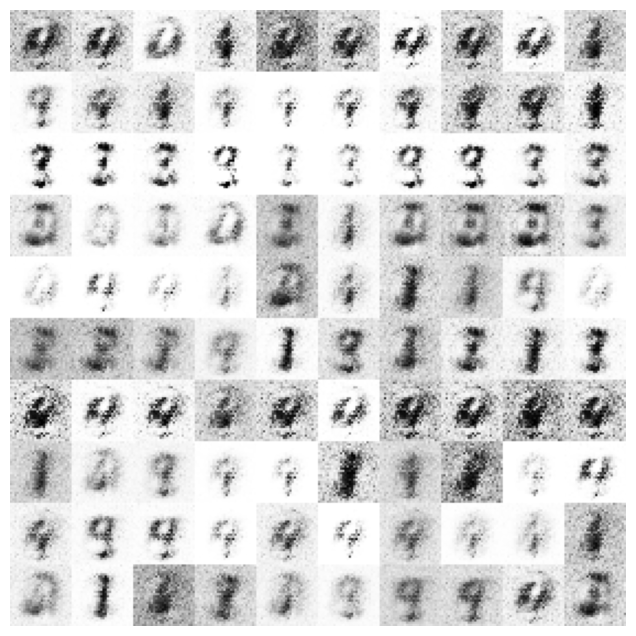

Epoch: 5, Generator loss: 11.0819, Discriminator loss: 0.2037
Epoch: 5, Generator loss: 12.9389, Discriminator loss: 0.0871
Epoch: 5, Generator loss: 5.9334, Discriminator loss: 0.3064
Epoch: 5, Generator loss: 13.6947, Discriminator loss: 0.6013
----------------------------------------------------------------
Epoch: 6, Generator loss: 10.5461, Discriminator loss: 0.5207
Epoch: 6, Generator loss: 7.4826, Discriminator loss: 0.2801
Epoch: 6, Generator loss: 11.0053, Discriminator loss: 0.2456
Epoch: 6, Generator loss: 7.9919, Discriminator loss: 0.3673
----------------------------------------------------------------
Epoch: 7, Generator loss: 5.4189, Discriminator loss: 0.4900
Epoch: 7, Generator loss: 6.7468, Discriminator loss: 0.3209
Epoch: 7, Generator loss: 8.1091, Discriminator loss: 0.2701
Epoch: 7, Generator loss: 9.6683, Discriminator loss: 0.1672
Epoch: 7, Generator loss: 11.1171, Discriminator loss: 0.1058
----------------------------------------------------------------
Epoch:

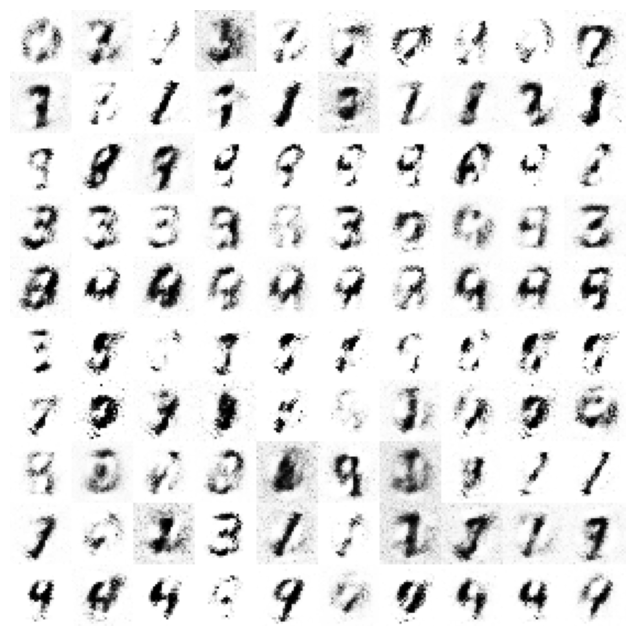

Epoch: 9, Generator loss: 9.5336, Discriminator loss: 0.4105
Epoch: 9, Generator loss: 10.0394, Discriminator loss: 0.5435
Epoch: 9, Generator loss: 7.6397, Discriminator loss: 0.4191
Epoch: 9, Generator loss: 7.1796, Discriminator loss: 0.4095
----------------------------------------------------------------
Epoch: 10, Generator loss: 9.5278, Discriminator loss: 0.3994
Epoch: 10, Generator loss: 7.9962, Discriminator loss: 0.6421
Epoch: 10, Generator loss: 9.7367, Discriminator loss: 0.4360
Epoch: 10, Generator loss: 6.3514, Discriminator loss: 0.5204
----------------------------------------------------------------
Epoch: 11, Generator loss: 7.4404, Discriminator loss: 0.5568
Epoch: 11, Generator loss: 8.1185, Discriminator loss: 0.5584
Epoch: 11, Generator loss: 6.0574, Discriminator loss: 0.9750
Epoch: 11, Generator loss: 7.3965, Discriminator loss: 0.6408
----------------------------------------------------------------
Epoch: 12, Generator loss: 7.6377, Discriminator loss: 0.4822
Ep

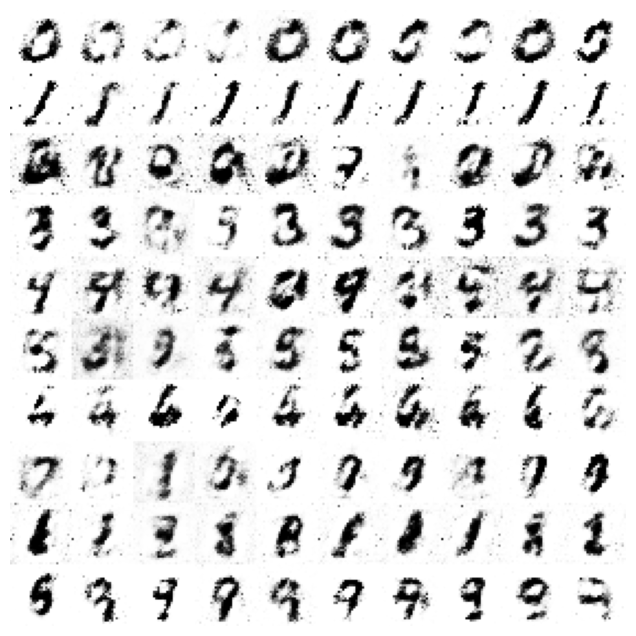

Epoch: 13, Generator loss: 5.7928, Discriminator loss: 0.8019
Epoch: 13, Generator loss: 6.3712, Discriminator loss: 0.7163
Epoch: 13, Generator loss: 7.2327, Discriminator loss: 0.7610
Epoch: 13, Generator loss: 5.0522, Discriminator loss: 0.7947
----------------------------------------------------------------
Epoch: 14, Generator loss: 6.0267, Discriminator loss: 0.7340
Epoch: 14, Generator loss: 4.7870, Discriminator loss: 0.7504
Epoch: 14, Generator loss: 4.8115, Discriminator loss: 1.0004
Epoch: 14, Generator loss: 5.3400, Discriminator loss: 0.6896
----------------------------------------------------------------
Epoch: 15, Generator loss: 4.6438, Discriminator loss: 0.8167
Epoch: 15, Generator loss: 6.2418, Discriminator loss: 0.7881
Epoch: 15, Generator loss: 5.7551, Discriminator loss: 1.0259
Epoch: 15, Generator loss: 5.3622, Discriminator loss: 0.7985
Epoch: 15, Generator loss: 4.9127, Discriminator loss: 1.2940
----------------------------------------------------------------

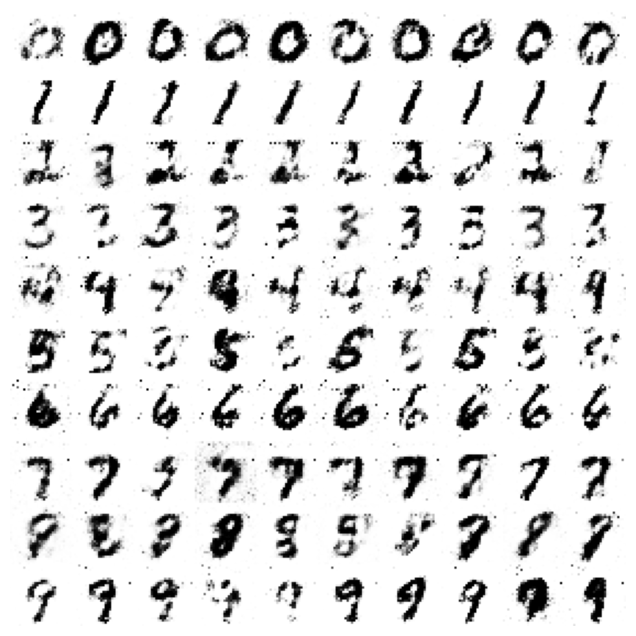

Epoch: 17, Generator loss: 5.2815, Discriminator loss: 1.1060
Epoch: 17, Generator loss: 5.3869, Discriminator loss: 0.9670
Epoch: 17, Generator loss: 4.6301, Discriminator loss: 0.9428
Epoch: 17, Generator loss: 5.1135, Discriminator loss: 1.0022
----------------------------------------------------------------
Epoch: 18, Generator loss: 4.7486, Discriminator loss: 0.9300
Epoch: 18, Generator loss: 5.5277, Discriminator loss: 1.0636
Epoch: 18, Generator loss: 5.7527, Discriminator loss: 1.0038
Epoch: 18, Generator loss: 3.7855, Discriminator loss: 0.7064
----------------------------------------------------------------
Epoch: 19, Generator loss: 5.7001, Discriminator loss: 0.7274
Epoch: 19, Generator loss: 4.4582, Discriminator loss: 0.8975
Epoch: 19, Generator loss: 5.1106, Discriminator loss: 0.7255
Epoch: 19, Generator loss: 4.8825, Discriminator loss: 0.9009
----------------------------------------------------------------
Epoch: 20, Generator loss: 3.7523, Discriminator loss: 0.9754

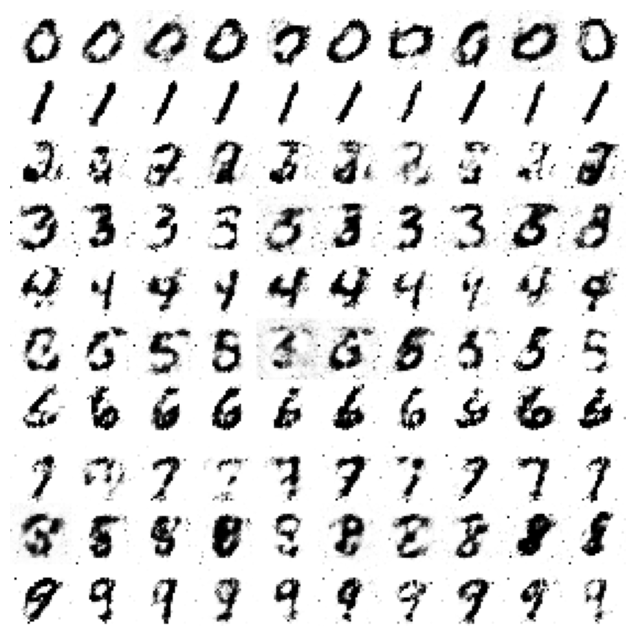

Epoch: 21, Generator loss: 3.9664, Discriminator loss: 1.1668
Epoch: 21, Generator loss: 4.1629, Discriminator loss: 1.0339
Epoch: 21, Generator loss: 4.8527, Discriminator loss: 0.9955
Epoch: 21, Generator loss: 4.8771, Discriminator loss: 1.3249
----------------------------------------------------------------
Epoch: 22, Generator loss: 3.6763, Discriminator loss: 1.3201
Epoch: 22, Generator loss: 4.0188, Discriminator loss: 1.2079
Epoch: 22, Generator loss: 4.1219, Discriminator loss: 1.1848
Epoch: 22, Generator loss: 3.6232, Discriminator loss: 1.1507
----------------------------------------------------------------
Epoch: 23, Generator loss: 3.6651, Discriminator loss: 1.0448
Epoch: 23, Generator loss: 3.1196, Discriminator loss: 1.0831
Epoch: 23, Generator loss: 3.6360, Discriminator loss: 1.1332
Epoch: 23, Generator loss: 3.8244, Discriminator loss: 1.1920
Epoch: 23, Generator loss: 3.3632, Discriminator loss: 1.4065
----------------------------------------------------------------

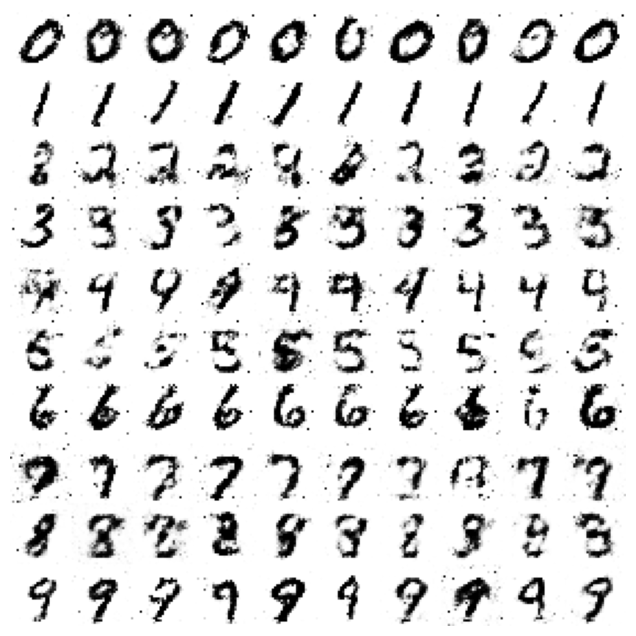

Epoch: 25, Generator loss: 4.6133, Discriminator loss: 1.1736
Epoch: 25, Generator loss: 3.3700, Discriminator loss: 1.1553
Epoch: 25, Generator loss: 4.9614, Discriminator loss: 1.0240
Epoch: 25, Generator loss: 4.7167, Discriminator loss: 1.2559
----------------------------------------------------------------
Epoch: 26, Generator loss: 3.1557, Discriminator loss: 1.0963
Epoch: 26, Generator loss: 4.5019, Discriminator loss: 1.3699
Epoch: 26, Generator loss: 4.7429, Discriminator loss: 1.0263
Epoch: 26, Generator loss: 3.8924, Discriminator loss: 1.1206
----------------------------------------------------------------
Epoch: 27, Generator loss: 3.8471, Discriminator loss: 1.0822
Epoch: 27, Generator loss: 3.7827, Discriminator loss: 1.0787
Epoch: 27, Generator loss: 3.6221, Discriminator loss: 1.4446
Epoch: 27, Generator loss: 4.0910, Discriminator loss: 1.1625
----------------------------------------------------------------
Epoch: 28, Generator loss: 3.3355, Discriminator loss: 1.0236

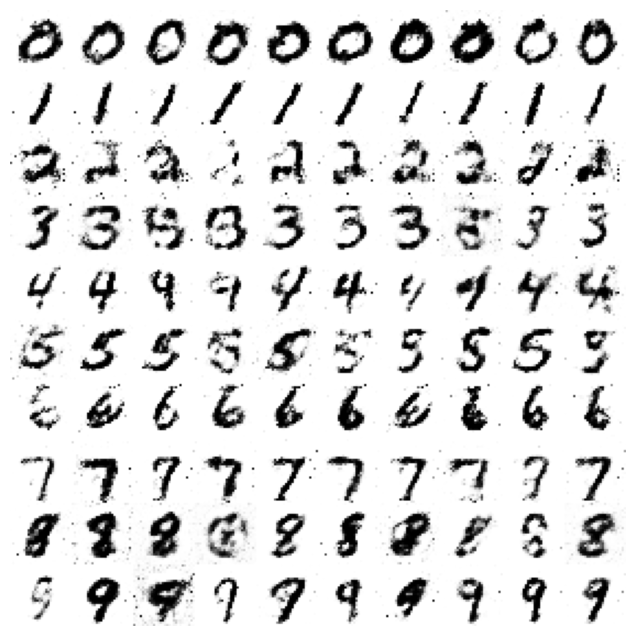

Epoch: 29, Generator loss: 3.4635, Discriminator loss: 1.2607
Epoch: 29, Generator loss: 4.2680, Discriminator loss: 1.1641
Epoch: 29, Generator loss: 3.9639, Discriminator loss: 1.2157
Epoch: 29, Generator loss: 3.7832, Discriminator loss: 1.2220
----------------------------------------------------------------
Epoch: 30, Generator loss: 3.5429, Discriminator loss: 1.2938
Epoch: 30, Generator loss: 3.1926, Discriminator loss: 1.2612
Epoch: 30, Generator loss: 4.5133, Discriminator loss: 1.2143
Epoch: 30, Generator loss: 4.1770, Discriminator loss: 1.2385
Epoch: 30, Generator loss: 4.2165, Discriminator loss: 0.8926
----------------------------------------------------------------
Epoch: 31, Generator loss: 3.9857, Discriminator loss: 1.1721
Epoch: 31, Generator loss: 3.6765, Discriminator loss: 1.2491
Epoch: 31, Generator loss: 3.8402, Discriminator loss: 1.2421
Epoch: 31, Generator loss: 2.8079, Discriminator loss: 1.4834
----------------------------------------------------------------

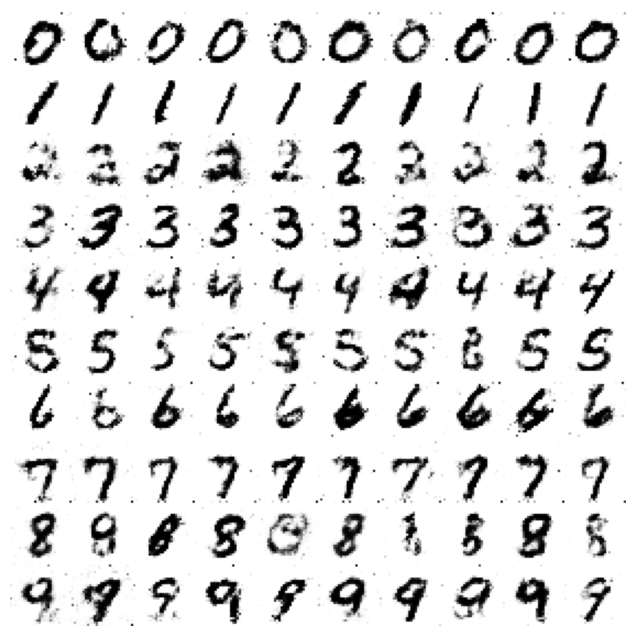

Epoch: 33, Generator loss: 3.5426, Discriminator loss: 1.1611
Epoch: 33, Generator loss: 4.2812, Discriminator loss: 1.2492
Epoch: 33, Generator loss: 3.2068, Discriminator loss: 1.2084
Epoch: 33, Generator loss: 3.6931, Discriminator loss: 1.1465
----------------------------------------------------------------
Epoch: 34, Generator loss: 3.3326, Discriminator loss: 1.3027
Epoch: 34, Generator loss: 3.2298, Discriminator loss: 1.2871
Epoch: 34, Generator loss: 3.1607, Discriminator loss: 1.4685
Epoch: 34, Generator loss: 4.4712, Discriminator loss: 1.1250
----------------------------------------------------------------
Epoch: 35, Generator loss: 3.7390, Discriminator loss: 1.3686
Epoch: 35, Generator loss: 3.8263, Discriminator loss: 1.1877
Epoch: 35, Generator loss: 2.9809, Discriminator loss: 1.3126
Epoch: 35, Generator loss: 2.4828, Discriminator loss: 1.2308
----------------------------------------------------------------
Epoch: 36, Generator loss: 3.1601, Discriminator loss: 1.4240

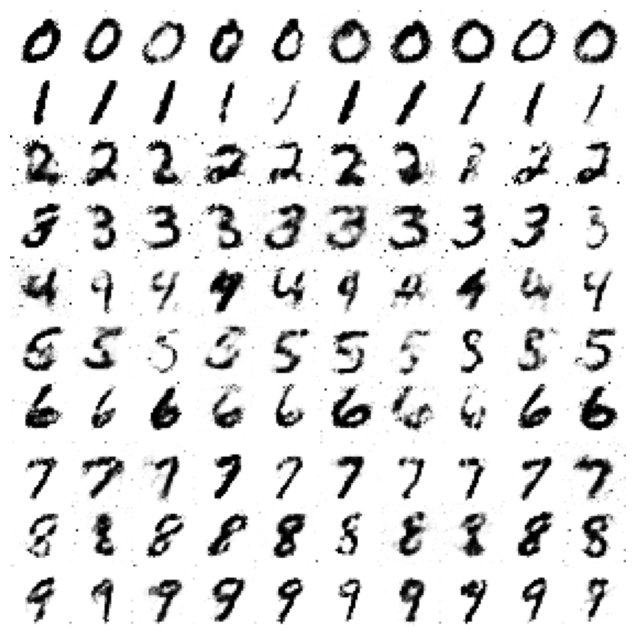

Epoch: 37, Generator loss: 3.7385, Discriminator loss: 1.3503
Epoch: 37, Generator loss: 3.6124, Discriminator loss: 1.4352
Epoch: 37, Generator loss: 3.0981, Discriminator loss: 1.3588
Epoch: 37, Generator loss: 5.1537, Discriminator loss: 1.5446
----------------------------------------------------------------
Epoch: 38, Generator loss: 2.9037, Discriminator loss: 1.3243
Epoch: 38, Generator loss: 4.6237, Discriminator loss: 1.3569
Epoch: 38, Generator loss: 3.3966, Discriminator loss: 1.3375
Epoch: 38, Generator loss: 3.3240, Discriminator loss: 1.2835
Epoch: 38, Generator loss: 2.7821, Discriminator loss: 1.3266
----------------------------------------------------------------
Epoch: 39, Generator loss: 3.1153, Discriminator loss: 1.2274
Epoch: 39, Generator loss: 2.4122, Discriminator loss: 1.4699
Epoch: 39, Generator loss: 2.1150, Discriminator loss: 1.6438
Epoch: 39, Generator loss: 2.4780, Discriminator loss: 1.5211
----------------------------------------------------------------

In [18]:
train(epochs)

## Visualization

In [19]:
filename = "cgan_generation_over_time.mp4"
pil_to_video(grid_images, filename, fps=8)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (280, 280) to (288, 288) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55d1180] Warning: data is not aligned! This can lead to a speed loss


In [20]:
display(Video(filename, embed=True))

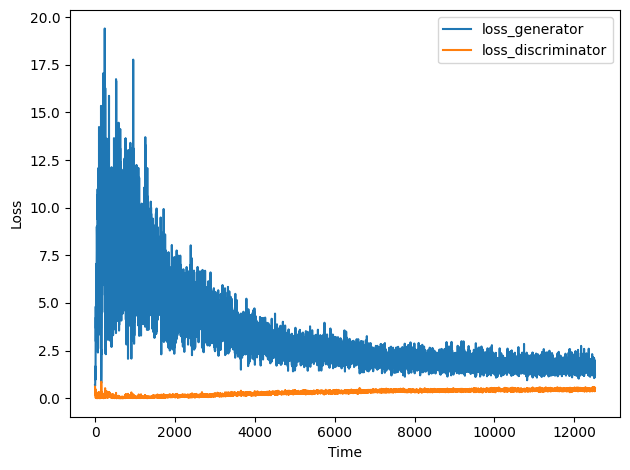

In [21]:
plt.plot(generator_losses, label="loss_generator")
plt.plot(discriminator_losses, label="loss_discriminator")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend()
plt.show()

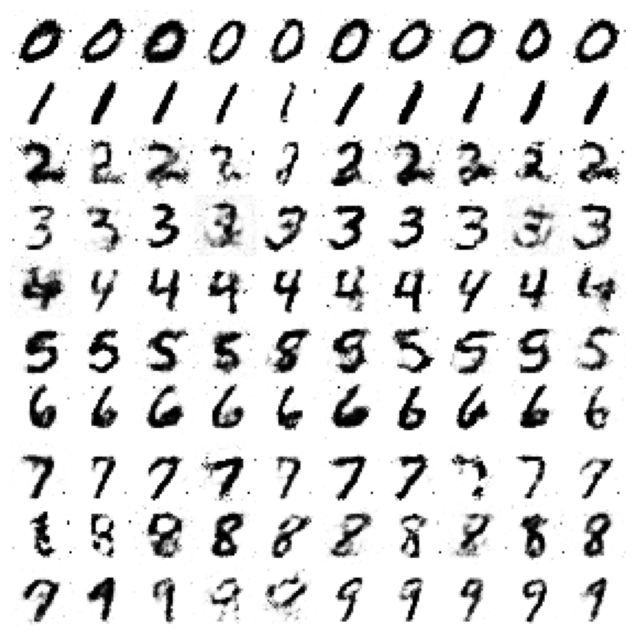

In [22]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(visualize(), cmap="binary")
plt.axis("off")
plt.show()